In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
ticker = 'MEGA.bk'
data = yf.Ticker(ticker)
print(data.info)
print(data.info['currentPrice'])
currentprice = data.info['currentPrice']

{'address1': '909, Ample Tower', 'address2': '9th floor Debaratna Road Bangna Nuea, Bangna', 'city': 'Bangkok', 'zip': '10260', 'country': 'Thailand', 'phone': '66 2 769 4222', 'fax': '66 2 769 4244', 'website': 'https://www.megawecare.com', 'industry': 'Drug Manufacturers - Specialty & Generic', 'industryKey': 'drug-manufacturers-specialty-generic', 'industryDisp': 'Drug Manufacturers - Specialty & Generic', 'sector': 'Healthcare', 'sectorKey': 'healthcare', 'sectorDisp': 'Healthcare', 'longBusinessSummary': "Mega Lifesciences Public Company Limited, together with its subsidiaries, manufactures and sells health food supplements, prescription pharmaceutical products, over-the-counter products, herbal products, vitamins, and fast-moving consumer goods in Southeast Asia and Sub-Saharan Africa. The company operates in three segments: Brands, Distribution, and Original Equipment Manufacture (OEM). It provides various medicines for allergies; blood circulation and memory; bone and joint; li

In [3]:
### - get > Average Free cash flow , shares , Net Debt = Long Term Borrowings - Cash ###

## Shares ## 
shares = data.info['sharesOutstanding']
print('Ticker = ',ticker,' Shares = ',shares)

## Net Debt = Long Term Borrowings - Cash ###
try:
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Total Non Current Liabilities Net Minority Interest'].values[0][0] - data.balancesheet.loc[data.balancesheet.index == 'Cash And Cash Equivalents'].values[0][0]
except:
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Long Term Debt And Capital Lease Obligation'].values[0][0] - data.balancesheet.loc[data.balancesheet.index == 'Cash And Cash Equivalents'].values[0][0]
print('Ticker = ',ticker,' Net Debt = ',totalnoncurrentliabilities)

## Average Free Cash Flow ## 
year = 4
averagefreecashflow = data.cash_flow.T['Free Cash Flow'].dropna()[:year].mean()
print(data.cash_flow.T['Free Cash Flow'].dropna()[:year])
print('Ticker = ',ticker,'Average Free Cash Flow = ',averagefreecashflow)

Ticker =  MEGA.bk  Shares =  871870016
Ticker =  MEGA.bk  Net Debt =  -1980612000.0
2023-12-31    1632912000.0
2022-12-31    1683881000.0
2021-12-31    2567048000.0
2020-12-31    1374361000.0
Name: Free Cash Flow, dtype: object
Ticker =  MEGA.bk Average Free Cash Flow =  1814550500.0


In [4]:
##### Create a DCF Function ######
dr = 0.10
tgr = 0.02
year_growth = 3
year_sustain = 7
growth_to_sustain_ratio = 0.3

def intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    return (np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares

print(ticker + ' Intrinsic Value = ',
      intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        0.15
        ))

MEGA.bk Intrinsic Value =  43.904972574542626


In [5]:
### Put current price as a target ### 

def intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    # print((((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares)) , currentprice)
    return (((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares) - currentprice)/currentprice

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        0.3288461864681969
        )*100," % ")

112.56800125983648  % 


In [6]:
def newton_raphson_method(initial_guess, tolerance, max_iterations,
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice):
    
    x_n = initial_guess
    for iteration in range(max_iterations):
    # while (True):
        f_x = intrinsic_value_diff_currentprice(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice,
            x_n
        )

        if abs(f_x) < tolerance :
            break

        x_n = x_n - f_x * 0.01

    return x_n

In [7]:
### test ###
initial_guess = 0.01
tolerance = 0.01
max_iterations = 100000

root = newton_raphson_method(initial_guess, tolerance, max_iterations,           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice)

print("Estimated GR:", root)

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        root
        ) * 100," % ")


Estimated GR: 0.11669909115324308
-0.9701224608536347  % 


Text(0.5, 1.0, 'MEGA.bk')

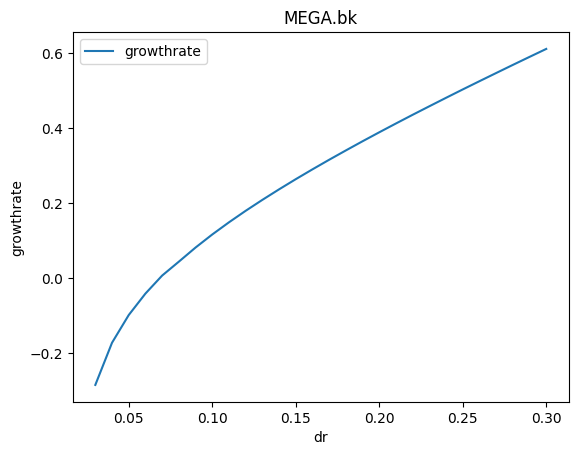

In [8]:
dr_list = [dr*0.01 for dr in range(int((tgr*100)+1),31,1)]
df = pd.DataFrame(index=dr_list,columns=['growthrate'])

growthrate = [ newton_raphson_method(initial_guess, tolerance, max_iterations,           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice) for dr in dr_list]
df['growthrate'] = growthrate
df.plot(xlabel='dr', ylabel='growthrate').set_title(ticker)